In [4]:
import os
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance as lgbm_plot_importance, early_stopping, log_evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from generate_features import generate_features


In [5]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# Also ensure the log CSV exists
log_file = "logs/model_log.csv"
if not os.path.exists(log_file):
    with open(log_file, "w") as f:
        f.write("model_id,model_type,AUC,date,params,notes\n")


In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Assumes train_df and test_df are already loaded

# Case 1: Normal training and testing with IDs
X_normal, y_normal, test_normal, features_normal = generate_features(
    train_df, test_df,
    return_feature_names=True,
    shuffle_train_id=False,
    shuffle_test_id=False,
    drop_id_completely=False
)

# # Case 2: Train with ID, test with SHUFFLED ID
# X_trainID_testShuffled, y_trainID_testShuffled, test_trainID_testShuffled, features_trainID_testShuffled = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=False,
#     shuffle_test_id=True,
#     drop_id_completely=False
# )

# # Case 3: Train with SHUFFLED ID, test with normal ID
# X_trainShuffledID, y_trainShuffledID, test_trainShuffledID, features_trainShuffledID = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=True,
#     shuffle_test_id=False,
#     drop_id_completely=False
# )

# # Case 4: Train and test with NO ID at all
# X_noID, y_noID, test_noID, features_noID = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=False,
#     shuffle_test_id=False,
#     drop_id_completely=True
# )

# # Case 5: Train and test with SHUFFLED IDs in both
# X_bothShuffled, y_bothShuffled, test_bothShuffled, features_bothShuffled = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=True,
#     shuffle_test_id=True,
#     drop_id_completely=False
# )


# #Case 6: Train with ID, test with completely random ID
# X_trainID_testRandom, y_trainID_testRandom, test_trainID_testRandom, features_trainID_testRandom = generate_features(
#     train_df, test_df,
#   return_feature_names=True,
#     shuffle_train_id=False,
#     shuffle_test_id=False,
#     drop_id_completely=False,
#     inject_random_test_id=True)

C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_24220\225490673.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("train.csv")
C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_24220\225490673.py:2: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("test.csv")


In [7]:
def run_knn_model(model_id, params, notes):
    model_type = "KNN"
    model = KNeighborsClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        auc = roc_auc_score(y[val_idx], val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)



In [8]:
def run_logreg_model(model_id, params, notes, feature_names=None):
    model_type = "LogReg"
    model = LogisticRegression(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        auc = roc_auc_score(y[val_idx], val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    if feature_names is not None and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        indices = np.argsort(importances)[-10:][::-1]
        plt.barh([feature_names[i] for i in indices], importances[indices])
        plt.xlabel("Feature importance (abs coef)")
        plt.title(f"Top 10 Feature Importances ({model_id})")
        plt.tight_layout()
        plt.show()



In [9]:
def run_svm_model(model_id, params, notes):
    model_type = "SVM"
    model = SVC(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    X_small, y_small = resample(X, y, n_samples=5000, stratify=y, random_state=42)

    for train_idx, val_idx in skf.split(X_small, y_small):
        model.fit(X_small[train_idx], y_small[train_idx])
        val_scores = model.decision_function(X_small[val_idx])
        auc = roc_auc_score(y_small[val_idx], val_scores)
        aucs.append(auc)
        test_preds += model.decision_function(test) / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

In [10]:
def run_adaboost_model(model_id, params, notes, feature_names):
    model_type = "AdaBoost"
    base = DecisionTreeClassifier(max_depth=2)
    model = AdaBoostClassifier(estimator=base, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()

In [11]:
def run_xgb_model(model_id, params, notes, X, y, test, feature_names):
    from xgboost import XGBClassifier, plot_importance
    model_type = "XGBoost"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = XGBClassifier(**params, n_estimators=10000)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30,
            verbose=100
        )

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]
        train_auc = roc_auc_score(y_train, train_probs)
        val_auc = roc_auc_score(y_val, val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits
        models.append(model)

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(models[-1], f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ 
        "model_id": model_id, "model_type": model_type, "AUC": mean_auc, 
        "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes 
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot top 10 feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [12]:
def run_catboost_model(model_id, params, notes, feature_names):
    model_type = "CatBoost"
    model = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.get_feature_importance()
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [13]:
def run_lgbm_model(model_id, params, notes, feature_names):

    model_type = "LightGBM"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=1000
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                early_stopping(stopping_rounds=30),
                log_evaluation(period=100)
            ]
        )

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]

        train_auc = roc_auc_score(y_train, train_probs)
        val_auc = roc_auc_score(y_val, val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits
        models.append(model)

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(models[-1], f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot top 10 feature importances with real feature names
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    top_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(8, 5))
    plt.barh(range(10), importances[indices][::-1])
    plt.yticks(range(10), [top_names[i] for i in range(9, -1, -1)])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [14]:
def run_rf_model(model_id, params, notes, feature_names):
    model_type = "RandomForest"
    model = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()



🚀 Running lgbm_normal_v1...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.265707
[200]	valid_0's binary_logloss: 0.22973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.214525
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9898 | Val AUC: 0.9814


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.273623
[200]	valid_0's binary_logloss: 0.236945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.221004
[400]	valid_0's binary_logloss: 0.214173
[500]	valid_0's binary_logloss: 0.204147
[600]	valid_0's binary_logloss: 0.199237
[LightGBM] [Warning] No further splits with posi

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9902 | Val AUC: 0.9802


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.268948
[200]	valid_0's binary_logloss: 0.233109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.218151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9806


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.267389
[200]	valid_0's binary_logloss: 0.23377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.216531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.208402
[LightGBM] [Warning] No further splits with positive g

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9815


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.272375
[200]	valid_0's binary_logloss: 0.231153
[300]	valid_0's binary_logloss: 0.212886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9811


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_normal_v1): 0.980968


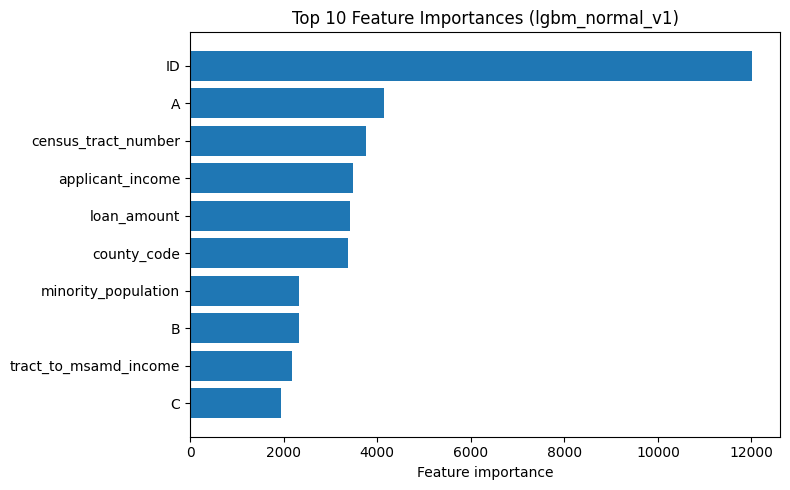


🚀 Running lgbm_normal_v2...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.276265
[200]	valid_0's binary_logloss: 0.232438
[300]	valid_0's binary_logloss: 0.214582
[400]	valid_0's binary_logloss: 0.206914
[500]	valid_0's binary_logloss: 0.201353
[600]	valid_0's binary_logloss: 0.196775
[700]	valid_0's binary_logloss: 0.193318
[800]	valid_0's binary_logloss: 0.190587
[900]	valid_

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9894 | Val AUC: 0.9803


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.282834
[200]	valid_0's binary_logloss: 0.240864
[300]	valid_0's binary_logloss: 0.221737
[400]	valid_0's binary_logloss: 0.212682
[500]	valid_0's binary_logloss: 0.207936
[600]	valid_0's binary_logloss: 0.203397
[700]	valid_0's binary_logloss: 0.199585
[800]	valid_0's binary_logloss: 0.196313
[900]	valid_0's binary_logloss: 0.193734


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9900 | Val AUC: 0.9790


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.280926
[200]	valid_0's binary_logloss: 0.237296
[300]	valid_0's binary_logloss: 0.218986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.209619
[500]	valid_0's binary_logloss: 0.202925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9902 | Val AUC: 0.9806


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3396
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.275218
[200]	valid_0's binary_logloss: 0.233105
[300]	valid_0's binary_logloss: 0.214467
[400]	valid_0's binary_logloss: 0.205117
[500]	valid_0's binary_logloss: 0.200084
[600]	valid_0's binary_logloss: 0.19587
[700]	valid_0's binary_logloss: 0.19191
[800]	valid_0's binary_logloss: 0.189243
[900]	valid_0's binary_logloss: 0.185256


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9900 | Val AUC: 0.9808


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.277758
[200]	valid_0's binary_logloss: 0.235773
[300]	valid_0's binary_logloss: 0.214285
[400]	valid_0's binary_logloss: 0.205737
[500]	valid_0's binary_logloss: 0.200981
[600]	valid_0's binary_logloss: 0.196374
[700]	valid_0's binary_logloss: 0.193522
[800]	valid_0's binary_logloss: 0.190402
[900]	valid_0's binary_logloss: 0.187124
[1000]	valid_0's binary_logloss: 0.183687
Did not mee

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9900 | Val AUC: 0.9805


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_normal_v2): 0.980216


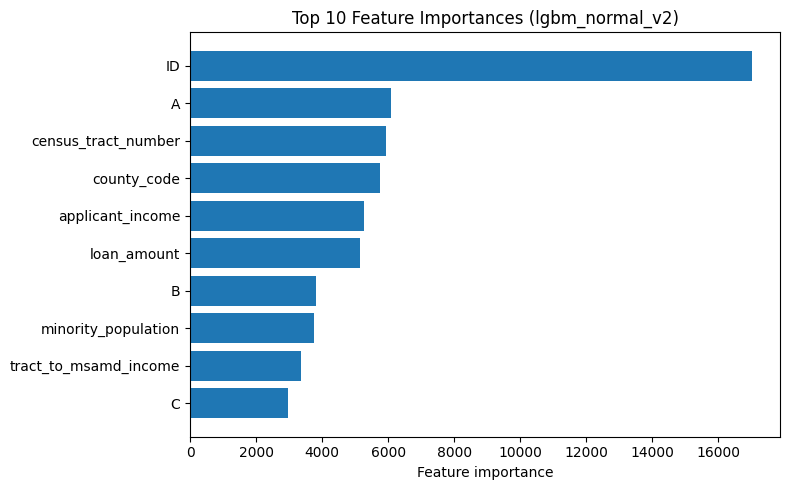


🚀 Running lgbm_normal_v3...

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.292276
[200]	valid_0's binary_logloss: 0.252968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9846 | Val AUC: 0.9791


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.300919
[200]	valid_0's binary_logloss: 0.259505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.235701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9850 | Val AUC: 0.9772


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.295264
[200]	valid_0's binary_logloss: 0.257122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.237696
[LightGBM] [Warning

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9852 | Val AUC: 0.9789


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3396
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.297059
[200]	valid_0's binary_logloss: 0.252622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.232073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

KeyboardInterrupt: 

In [16]:
# Parameter grids
lgbm_param_grid = [
    {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.045, 'subsample': 0.8, 'colsample_bytree': 0.9},
    {"num_leaves": 90, "max_depth": 10, "learning_rate": 0.03, "subsample": 0.9, "colsample_bytree": 0.9, "random_state": 42},
    {"num_leaves": 50, "max_depth": 7, "learning_rate": 0.035, "subsample": 0.95, "colsample_bytree": 0.95, "random_state": 42},
    {"num_leaves": 70, "max_depth": 8, "learning_rate": 0.03, "subsample": 0.85, "colsample_bytree": 0.9, "random_state": 42},
    {"num_leaves": 120, "max_depth": 14, "learning_rate": 0.02, "subsample": 0.95, "colsample_bytree": 0.85, "random_state": 42},
    {"num_leaves": 150, "max_depth": 16, "learning_rate": 0.015, "subsample": 1.0, "colsample_bytree": 0.95, "random_state": 42}

]

catboost_param_grid = [
    {"iterations": 500, "depth": 6, "learning_rate": 0.03, "loss_function": "Logloss", "verbose": 0, "random_seed": 42},
    {"iterations": 600, "depth": 8, "learning_rate": 0.025, "loss_function": "Logloss", "verbose": 0, "random_seed": 42},
    {"iterations": 700, "depth": 7, "learning_rate": 0.02, "loss_function": "Logloss", "verbose": 0, "random_seed": 42}
]
xgb_param_grid = [
    {"n_estimators": 10000, "max_depth": 6, "learning_rate": 0.035, "subsample": 0.9, "colsample_bytree": 0.9, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 5, "learning_rate": 0.03, "subsample": 0.85, "colsample_bytree": 0.8, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 4, "learning_rate": 0.02, "subsample": 1.0, "colsample_bytree": 1.0, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 5, "learning_rate": 0.015, "subsample": 0.9, "colsample_bytree": 0.85, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 3, "learning_rate": 0.01, "subsample": 0.95, "colsample_bytree": 0.95, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False}
]

rf_param_grid = [
    {"n_estimators": 300, "max_depth": 12, "min_samples_leaf": 2, "max_features": "sqrt", "bootstrap": True, "random_state": 42, "n_jobs": -1},
    {"n_estimators": 400, "max_depth": 15, "min_samples_leaf": 2, "max_features": 0.8, "bootstrap": True, "random_state": 42, "n_jobs": -1}
]
adaboost_param_grid = [
    {"n_estimators": 300, "learning_rate": 0.1, "random_state": 42},
    {"n_estimators": 500, "learning_rate": 0.05, "random_state": 42}
]
logreg_param_grid = [
    {"solver": "liblinear", "C": 1.0, "max_iter": 200},
    {"solver": "liblinear", "C": 0.5, "max_iter": 200}
]
svm_param_grid = [
    {"C": 1.0, "kernel": "linear", "probability": False, "random_state": 42},
    {"C": 0.5, "kernel": "linear", "probability": False, "random_state": 42}
]
knn_param_grid = [
    {"n_neighbors": 5},
    {"n_neighbors": 7}
]

# model_configs = [
#     ("lgbm", run_lgbm_model, lgbm_param_grid, X, y, True),
#     ("xgb", run_xgb_model, xgb_param_grid, X, y, True),
#     # ("rf", run_rf_model, rf_param_grid, X, y, True),
#     ("catboost", run_catboost_model, catboost_param_grid, X, y, False),
#     # ("adaboost", run_adaboost_model, adaboost_param_grid, X, y, True),
#     ("logreg", run_logreg_model, logreg_param_grid, X, y, True),
#     # ("svm", run_svm_model, svm_param_grid, X_small, y_small, False),
#     # ("knn", run_knn_model, knn_param_grid, X_small, y_small, False)
# ]

# # Run all model configs with all param sets
# for model_prefix, func, param_list, X_used, y_used, pass_features in model_configs:
#     for i, params in enumerate(param_list):
#         model_id = f"{model_prefix}_v{i+1}"
#         print(f"\n🚀 Running {model_id}...")

#         try:
#             if pass_features:
#                 func(model_id, params, f"{model_prefix.upper()} config #{i+1}", feature_names)
#             else:
#                 func(model_id, params, f"{model_prefix.upper()} config #{i+1}")
#         except Exception as e:
#             print(f"❌ ERROR in {model_id}: {e}")
#             continue  # Move to the next config
feature_sets = [
    # ("trainID_testRandom", X_trainID_testRandom, y_trainID_testRandom, test_trainID_testRandom, features_trainID_testRandom),
    ("normal", X_normal, y_normal, test_normal, features_normal),
    # ("testID_shuffled", X_trainID_testShuffled, y_trainID_testShuffled, test_trainID_testShuffled, features_trainID_testShuffled),
    # ("trainID_shuffled", X_trainShuffledID, y_trainShuffledID, test_trainShuffledID, features_trainShuffledID),
    # ("noID", X_noID, y_noID, test_noID, features_noID),
    # ("both_shuffled", X_bothShuffled, y_bothShuffled, test_bothShuffled, features_bothShuffled),
]

for name, X, y, test, feature_names in feature_sets:
    for i, params in enumerate(lgbm_param_grid):
        model_id = f"lgbm_{name}_v{i+1}"
        print(f"\n🚀 Running {model_id}...")
        try:
            run_lgbm_model(model_id, params, f"{name.upper()} config #{i+1}", feature_names)
        except Exception as e:
            print(f"❌ ERROR in {model_id}: {e}")

